In [52]:
import pandas as pd
import numpy as np
import mne_bids
import matplotlib.pyplot as plt
import warnings

##### Generate coordsystem.json for each sub-ses folder

In [5]:
# import os
# import json

# root_path = 'data' # path to the dataset folder

# coordsystem_content = {
#     "EEGCoordinateSystem": "CapTrak",
#     "EEGCoordinateUnits": "mm",
#     "AnatomicalLandmarkCoordinates": {
#         "NAS": [0, 103, -11],
#         "LPA": [-83, 0, -11],
#         "RPA": [83, 0, -11]
#     },
#     "AnatomicalLandmarkCoordinateUnits": "mm"
# }

# def save_json(file_path, data):
#     with open(file_path, 'w') as fp:
#         json.dump(data, fp, indent=4)

# # generate one for each sub-ses folder
# for subdir, dirs, files in os.walk(root_path):
#     if subdir.endswith('eeg'):
#         parts = subdir.split(os.sep)
#         prefix = parts[-3] + '_' + parts[-2]
#         json_file_path = os.path.join(subdir, f"{prefix}_coordsystem.json")
#         save_json(json_file_path, coordsystem_content)
#         print(f'coordsystem.json created at {json_file_path}')


In [53]:
# load one set of eeg data
bids_path = mne_bids.BIDSPath(subject='14', session='1', task='eyesopen', datatype='eeg', root='data') # modify root to path to the data folder
raw = mne_bids.read_raw_bids(bids_path)
raw.load_data()
print(raw.info)

Reading /Users/sallyyu/Desktop/sleepdeprivation_COGS138/sleepdeprivation_COGS138/data/sub-14/ses-1/eeg/sub-14_ses-1_task-eyesopen_eeg.fdt
Reading channel info from data/sub-14/ses-1/eeg/sub-14_ses-1_task-eyesopen_channels.tsv.
Reading electrode coords from data/sub-14/ses-1/eeg/sub-14_ses-1_electrodes.tsv.
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
<Info | 9 non-empty values
 bads: []
 ch_names: Fp1, AF3, AF7, Fz, F1, F3, F5, F7, FC1, FC3, FC5, FT7, Cz, C1, ...
 chs: 61 EEG
 custom_ref_applied: False
 dig: 64 items (3 Cardinal, 61 EEG)
 highpass: 0.0 Hz
 line_freq: 50.0
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 61
 projs: []
 sfreq: 500.0 Hz
>


/var/folders/tj/l3z3723s3mjg78mm81dj0jqw0000gn/T/ipykernel_64043/3833974829.py:3: RuntimeWarning: Did not find any events.tsv associated with sub-14_ses-1_task-eyesopen.

The search_str was "data/sub-14/**/eeg/sub-14_ses-1*events.tsv"
  raw = mne_bids.read_raw_bids(bids_path)
/var/folders/tj/l3z3723s3mjg78mm81dj0jqw0000gn/T/ipykernel_64043/3833974829.py:3: RuntimeWarning: participants.tsv file not found for data/sub-14/ses-1/eeg/sub-14_ses-1_task-eyesopen_eeg.set
  raw = mne_bids.read_raw_bids(bids_path)


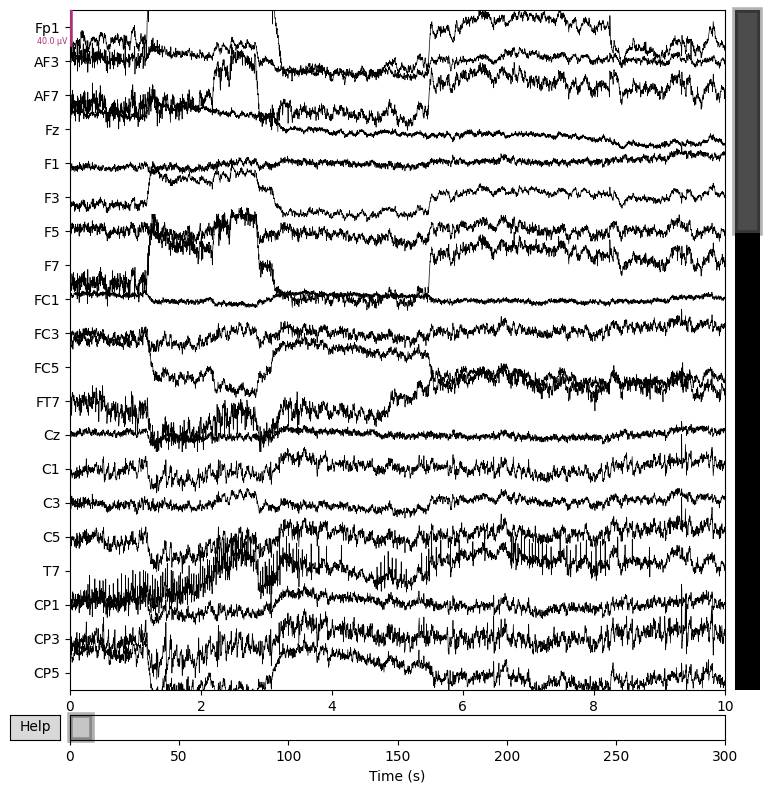

In [54]:
fig = raw.plot()

#### EDA on EEG data

In [59]:
df = pd.read_csv('cleaned_df.csv', index_col=0)
df.head()

,participant_id,Gender,Age,SessionOrder,PANAS_P_NS,PANAS_P_SD,PANAS_N_NS,PANAS_N_SD,SleepDiary_item1_NS,SleepDiary_item2_NS,SleepDiary_item3_NS,EQ,Buss_Perry,PSQI_GlobalScore,Sleep_time
13,sub-14,M,21,SD->NS,19,13.0,10,12.0,1:00,9:10,8.0,25.0,57.0,2.0,8:10
14,sub-15,M,19,SD->NS,22,11.0,14,17.0,2:00,8:00,8.0,31.0,71.0,6.0,6:00
15,sub-16,F,22,SD->NS,28,22.0,15,20.0,0:10,8:07,8.0,35.0,57.0,8.0,7:57
16,sub-17,F,18,SD->NS,36,21.0,20,23.0,0:14,8:03,7.0,40.0,58.0,6.0,7:49
17,sub-18,M,21,SD->NS,30,12.0,12,32.0,22:30,7:05,8.0,27.0,72.0,9.0,8:35


In [66]:
def str_time_to_int(time_str):
    hours, minutes = map(int, time_str.split(':'))
    return hours + minutes / 60.0

df['Sleep_time'] = df['Sleep_time'].apply(str_time_to_int)
df.head()

,participant_id,Gender,Age,SessionOrder,PANAS_P_NS,PANAS_P_SD,PANAS_N_NS,PANAS_N_SD,SleepDiary_item1_NS,SleepDiary_item2_NS,SleepDiary_item3_NS,EQ,Buss_Perry,PSQI_GlobalScore,Sleep_time
13,sub-14,M,21,SD->NS,19,13.0,10,12.0,1:00,9:10,8.0,25.0,57.0,2.0,8.166667
14,sub-15,M,19,SD->NS,22,11.0,14,17.0,2:00,8:00,8.0,31.0,71.0,6.0,6.000000
15,sub-16,F,22,SD->NS,28,22.0,15,20.0,0:10,8:07,8.0,35.0,57.0,8.0,7.950000
16,sub-17,F,18,SD->NS,36,21.0,20,23.0,0:14,8:03,7.0,40.0,58.0,6.0,7.816667
17,sub-18,M,21,SD->NS,30,12.0,12,32.0,22:30,7:05,8.0,27.0,72.0,9.0,8.583333


In [29]:
df[df['SessionOrder'] == 'NS->SD'].shape

(30, 14)

##### Plot a few EEG examples of participants to compare between normal sleep and sleep deprivation conditions

Reading /Users/sallyyu/Desktop/sleepdeprivation_COGS138/sleepdeprivation_COGS138/data/sub-14/ses-1/eeg/sub-14_ses-1_task-eyesopen_eeg.fdt
Reading channel info from data/sub-14/ses-1/eeg/sub-14_ses-1_task-eyesopen_channels.tsv.
Reading electrode coords from data/sub-14/ses-1/eeg/sub-14_ses-1_electrodes.tsv.
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Reading /Users/sallyyu/Desktop/sleepdeprivation_COGS138/sleepdeprivation_COGS138/data/sub-14/ses-2/eeg/sub-14_ses-2_task-eyesopen_eeg.fdt
Reading channel info from data/sub-14/ses-2/eeg/sub-14_ses-2_task-eyesopen_channels.tsv.
Reading electrode coords from data/sub-14/ses-2/eeg/sub-14_ses-2_electrodes.tsv.
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Reading /Users/sallyyu/Desktop/sleepdeprivation_COGS138/sleepdeprivation_COGS138/data/sub-15/ses-1/eeg/sub-15_ses-1_task-eyesopen_eeg.fdt
Reading channel info from data/sub-15/ses-1/eeg/sub-15_ses-1_task-eyesopen_channels.tsv.
Reading electrode coords from data/sub-15/s

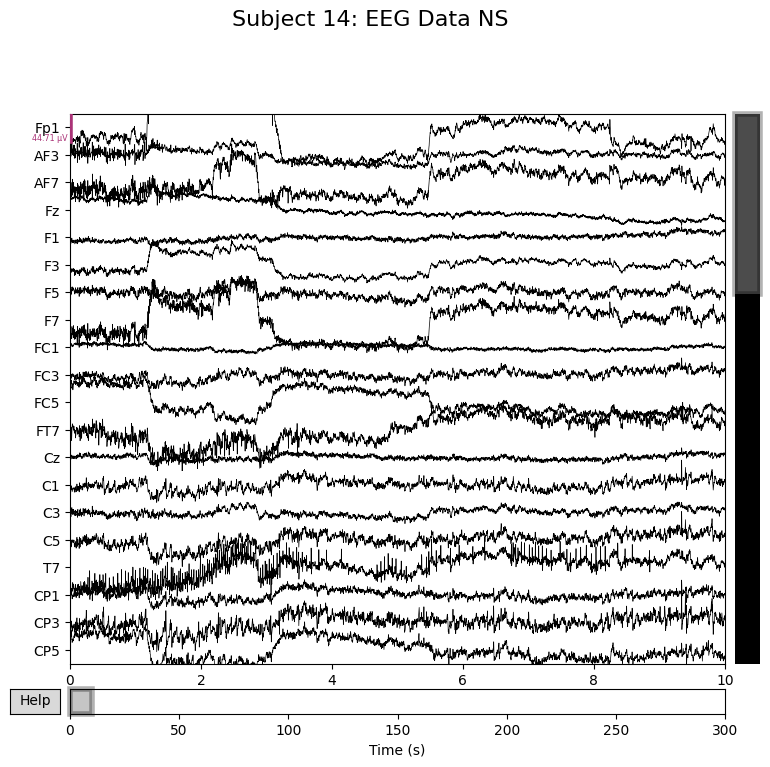

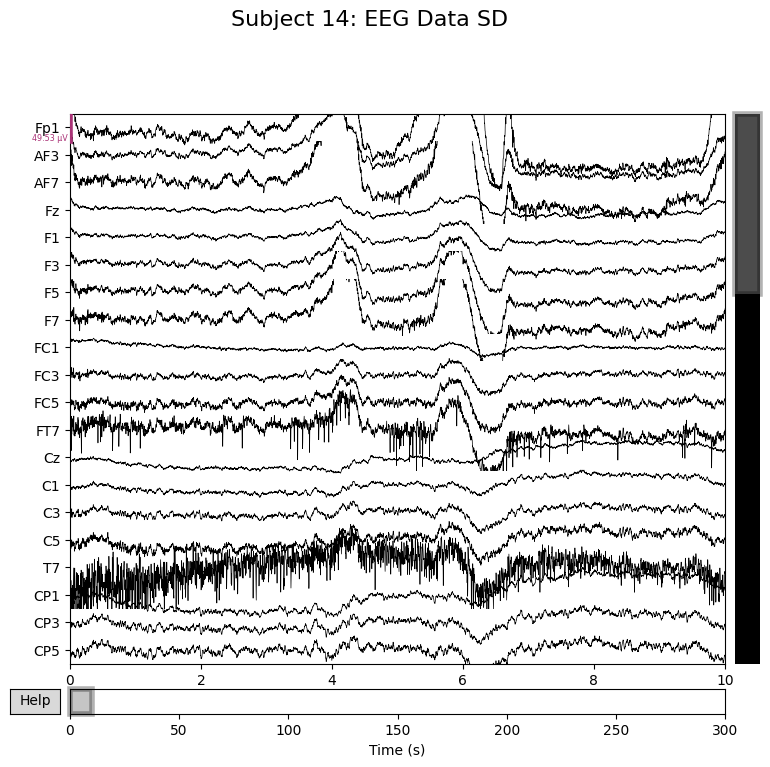

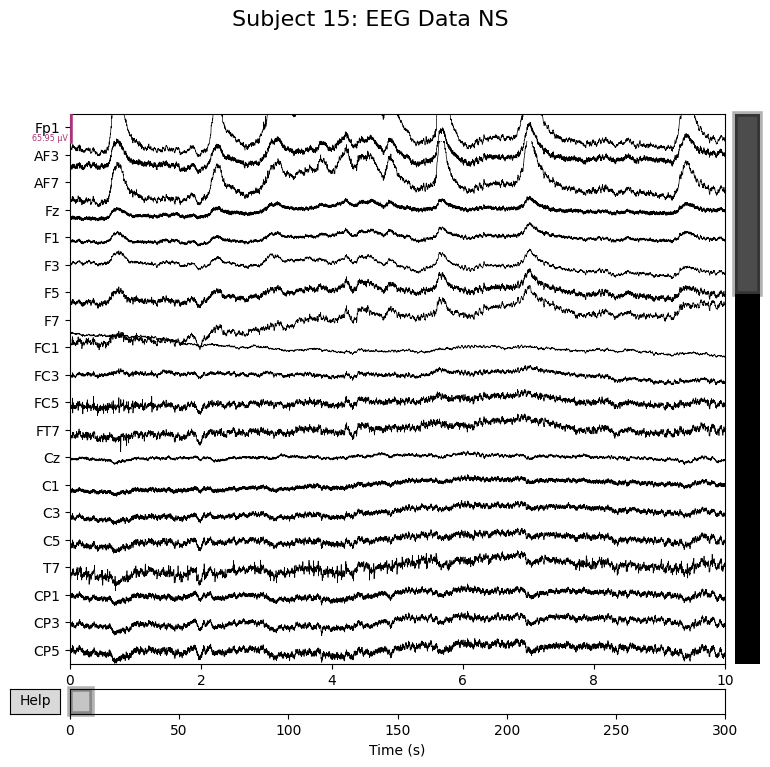

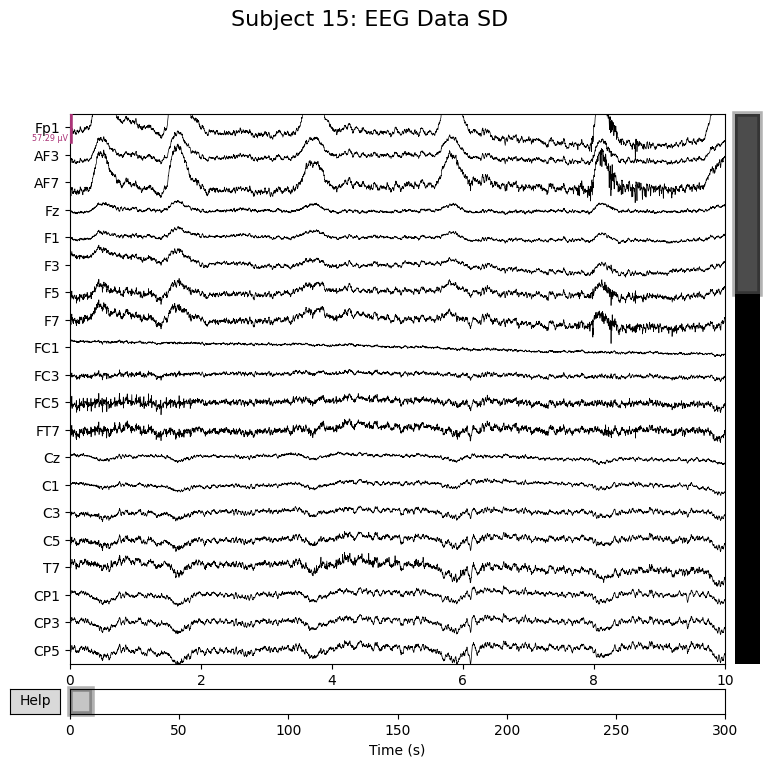

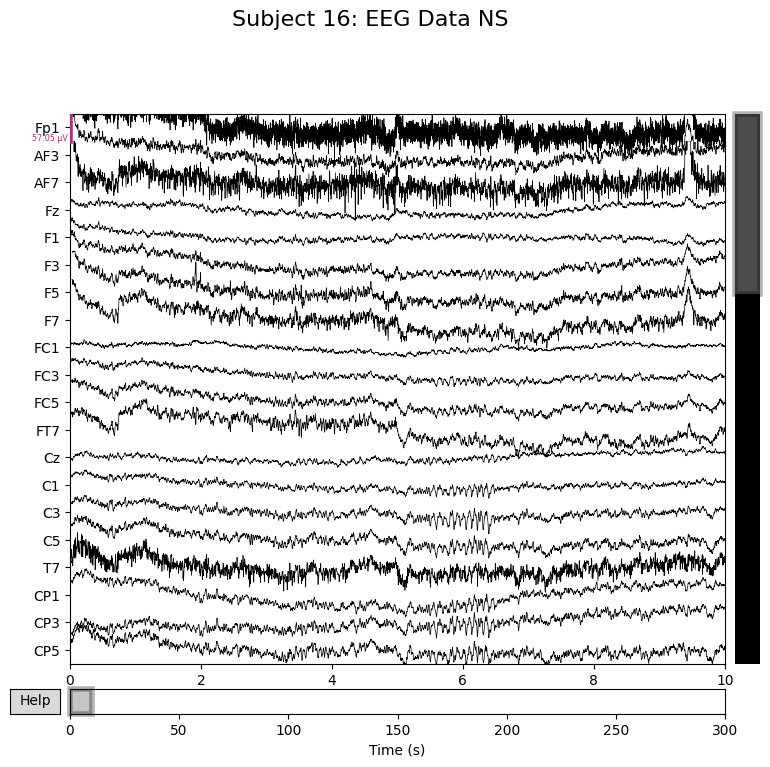

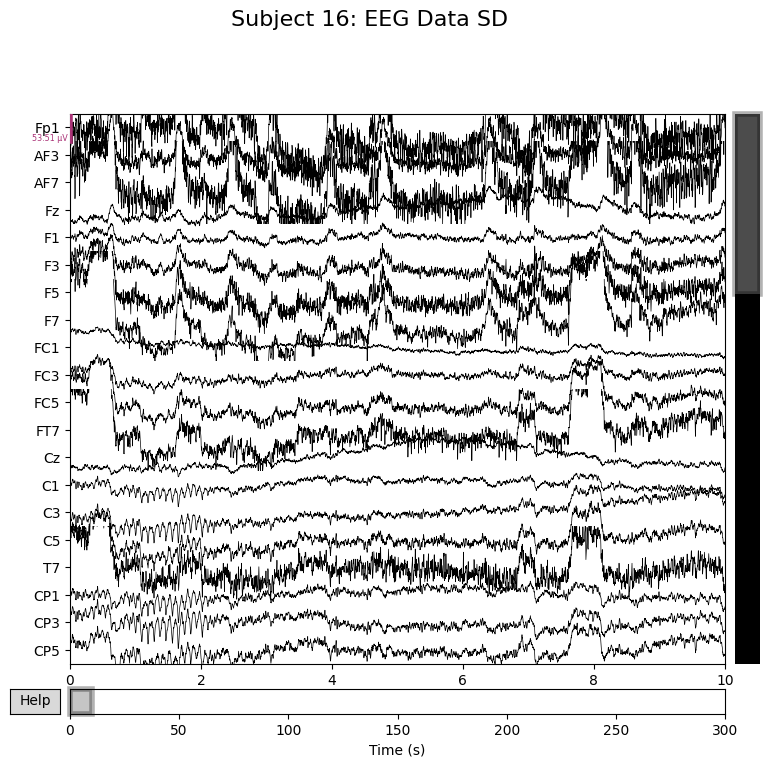

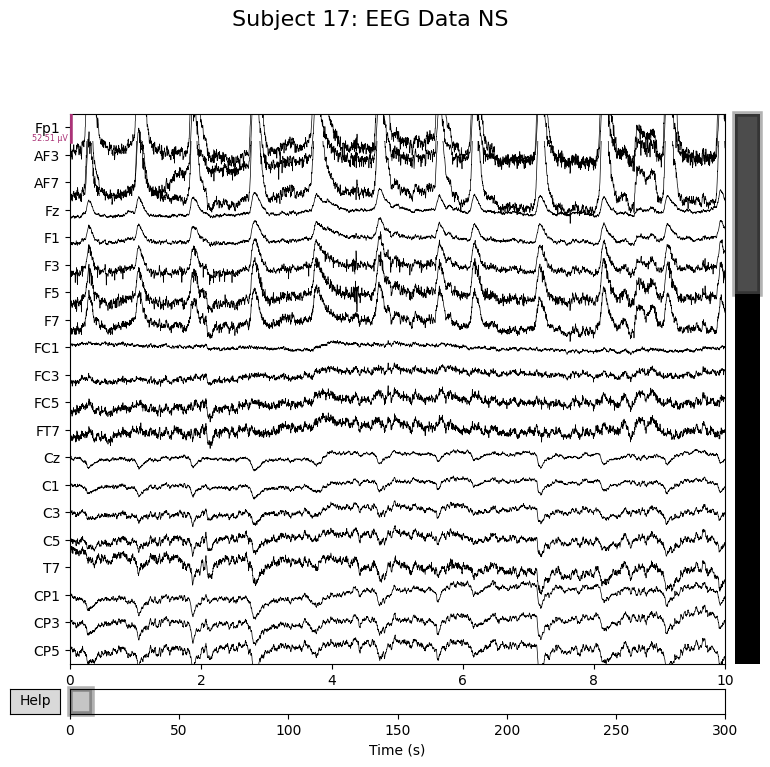

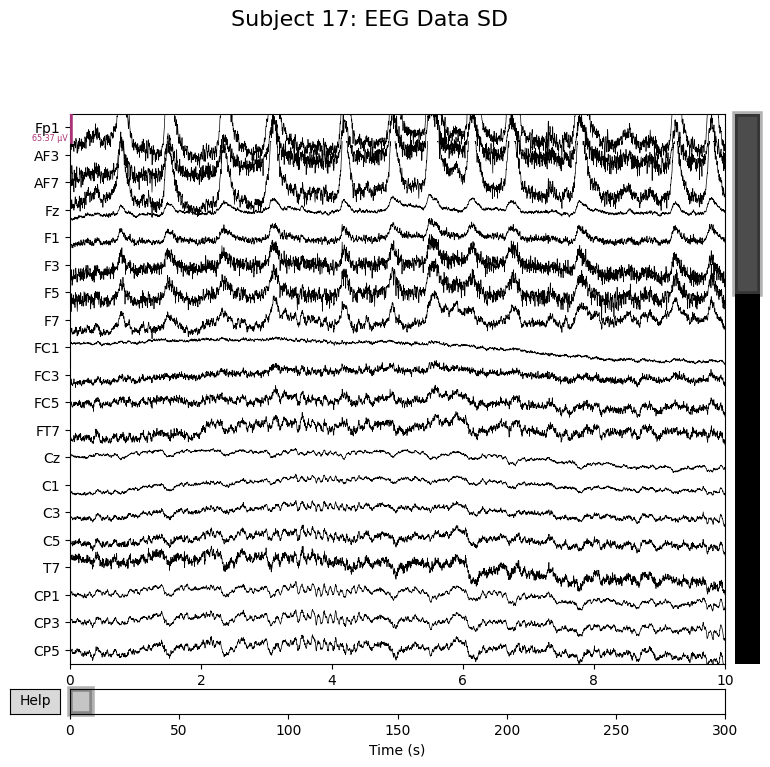

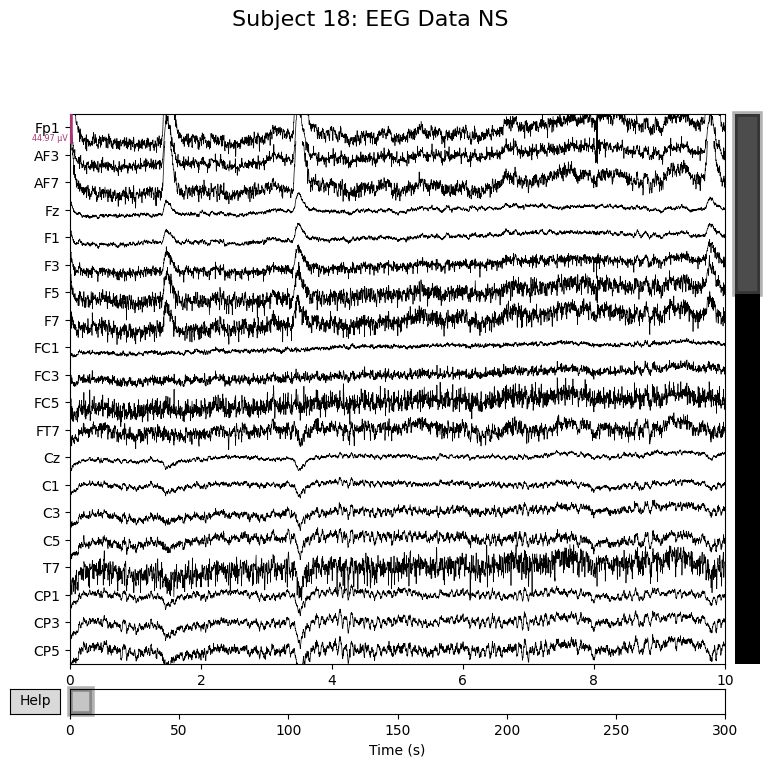

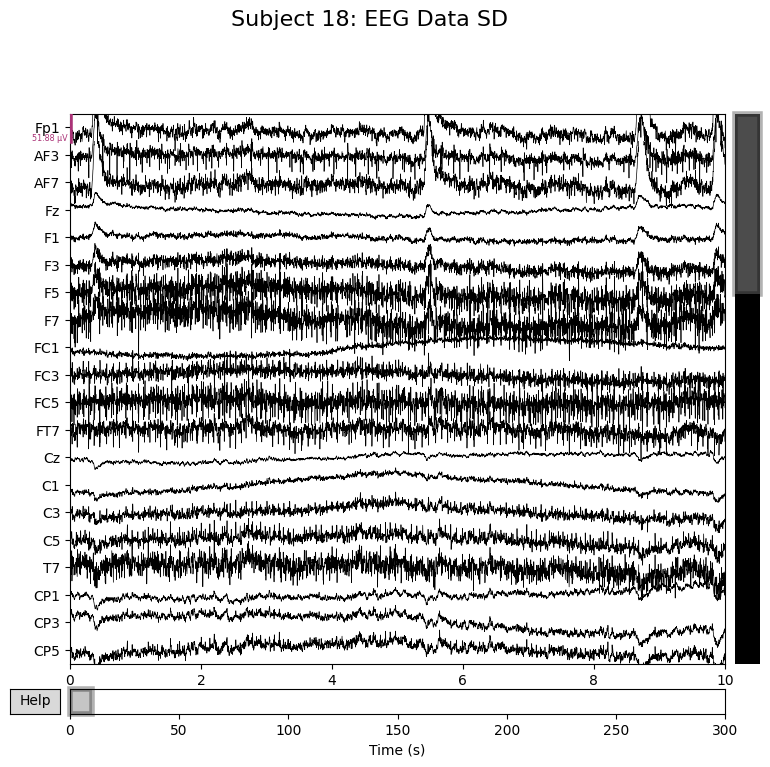

In [55]:
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Loop through the first 5 subjects
for i in df.index[:5]:
    if df.iloc[i].SessionOrder == 'SD->NS':
        ns_path = mne_bids.BIDSPath(subject=str(i+1), session='2', task='eyesopen', datatype='eeg', root='data')
        sd_path = mne_bids.BIDSPath(subject=str(i+1), session='1', task='eyesopen', datatype='eeg', root='data')
    else:
        ns_path = mne_bids.BIDSPath(subject=str(i+1), session='1', task='eyesopen', datatype='eeg', root='data')
        sd_path = mne_bids.BIDSPath(subject=str(i+1), session='2', task='eyesopen', datatype='eeg', root='data')

    raw = mne_bids.read_raw_bids(ns_path)
    raw.load_data()
    fig = raw.plot(scalings='auto', show=False, block=False)
    fig.suptitle(f'Subject {i+1}: EEG Data NS', fontsize=16)
    fig.subplots_adjust(top=0.85, bottom=0.1)

    raw = mne_bids.read_raw_bids(sd_path)
    raw.load_data()
    fig = raw.plot(scalings='auto', show=False, block=False)
    fig.suptitle(f'Subject {i+1}: EEG Data SD', fontsize=16)
    fig.subplots_adjust(top=0.85, bottom=0.1)

plt.show()


##### Restructure dataframe for model training

In [69]:
# features = ['Gender', 'Sleep_time', 'eeg']
# response = ['PSQI_GlobalScore']
# df['participant_id', 'Gender', 'NS/SD', 'Sleep_time', 'PSQI_GlobalScore']
feature_df = pd.DataFrame(columns=['participant_id', 'Condition', 'Gender', 'Age', 'SessionOrder', 'Sleep_time', 'PSQI_GlobalScore'])
new_rows = []
for i, row in df.iterrows():
    row1 = row[['participant_id', 'Gender', 'Age', 'SessionOrder', 'Sleep_time', 'PSQI_GlobalScore']]
    row2 = row[['participant_id', 'Gender', 'Age', 'SessionOrder', 'Sleep_time', 'PSQI_GlobalScore']]
    row1['Condition'] = 'NS'
    row2['Condition'] = 'SD'
    row2['Sleep_time'] = 0
    new_rows.append(row1)
    new_rows.append(row2)

feature_df = pd.concat(new_rows, axis=1).T.reset_index(drop=True)
feature_df

,participant_id,Gender,Age,SessionOrder,Sleep_time,PSQI_GlobalScore,Condition
0,sub-14,M,21,SD->NS,8.166667,2.0,NS
1,sub-14,M,21,SD->NS,0,2.0,SD
2,sub-15,M,19,SD->NS,6.0,6.0,NS
3,sub-15,M,19,SD->NS,0,6.0,SD
4,sub-16,F,22,SD->NS,7.95,8.0,NS
...,...,...,...,...,...,...,...
95,sub-67,F,21,SD->NS,0,6.0,SD
96,sub-68,F,21,SD->NS,7.5,5.0,NS
97,sub-68,F,21,SD->NS,0,5.0,SD
98,sub-69,F,18,NS->SD,3.25,6.0,NS
